In [35]:
""" 
"""

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from typing import Dict
from pyimzml.ImzMLParser import ImzMLParser
from chip_types_data_analysis import spectra_significant_features_threshold
from processing import process, aligned_representation, EqualWidthBinning
from utils import read_msi
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm

# Define current folder using this file
CWD = Path(".")
# Define folder that contains the dhg dataset
OPTIMIZATION_PATH = Path(os.path.join(CWD, "..", "data", "OPTIMIZATION"))
# Define folder that contains raw data
RAW_DATA = OPTIMIZATION_PATH.joinpath("raw")
# Define folder to save aligned data
ALIGNED_DATA = OPTIMIZATION_PATH.joinpath("aligned")
# Define folder to save processed data
PROCESSED_DATA = OPTIMIZATION_PATH.joinpath("processed")
# Define file that contains dhg metadata
METADATA_PATH = OPTIMIZATION_PATH.joinpath("metadata.csv")
# Define mass range start value
MZ_START = 50
# Define mass range end value
MZ_END = 1200
# Define mass resolution of the data
MASS_RESOLUTION = 0.025
# Define lock mass reference peak
LOCK_MASS_PEAK = 885.5498
# Define lock mass tol
LOCK_MASK_TOL = 0.3
# Define representative peaks
REPRESENTATIVE_PEAKS = [794.5, 834.5, 886.6]
# Define number of features thresholds
#THRESHOLDS = [1, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]
THRESHOLDS = [0.2, 0.4, 0.6, 0.8, 1.0]
# Define random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
# Define path to save figures
PLOT_PATH = CWD / "optimization"
# Create dirs
PLOT_PATH.mkdir(parents=True, exist_ok=True)

In [3]:
# Read metadata
metadata_df = pd.read_csv(METADATA_PATH)
# Define map from file to sample_file
file_to_sample_file_map = pd.Series(
    metadata_df.sample_file_name.values, index=metadata_df.file_name
).to_dict()

In [ ]:
def mean_tic(metadata_df):
  sample_tics = {}
  for _, roi in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
    #
    raw_path = os.path.join(ALIGNED_DATA, f"{roi.file_name}.imzML")
    #
    with ImzMLParser(raw_path) as reader:
      intensities = {}
      # Loop over each spectra in MSI
      for idx, _ in enumerate(reader.coordinates):
        raw_mzs, raw_intensities = reader.getspectrum(idx)
        for mz, intensity in zip(raw_mzs, raw_intensities):
          temp_intensities = intensities.get(mz, [])
          temp_intensities.append(intensity)
          intensities[mz] = temp_intensities
      sample_tics[roi.file_name] = np.array(
          [np.mean(intensities[mz]) for mz in intensities.keys()]
      ).sum()
  return sample_tics

In [ ]:
for _, roi in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
  common_representation_path = os.path.join(
      PROCESSED_DATA, f"{roi.sample_file_name}", "common_representation.imzML"
  )
  with ImzMLParser(common_representation_path) as p:
    # Read MSI data and get the intensity matrix
    mzs, msi = read_msi(p)
    #
    mean_spectra = np.mean(msi, axis=(0, 1))
    #
    zscored_spectra = ((mean_spectra - mean_spectra.mean()) + 1e-10) / (mean_spectra.std() + 1e-10)
    #
    zscores[roi.file_name] = zscored_spectra


In [24]:
zscores = {}

for _, roi in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
  common_representation_path = os.path.join(
      PROCESSED_DATA, f"{roi.sample_file_name}", "common_representation.imzML"
  )
  with ImzMLParser(common_representation_path) as p:
    # Read MSI data and get the intensity matrix
    mzs, msi = read_msi(p)
    #
    mean_spectra = np.mean(msi, axis=(0, 1))
    #
    zscored_spectra = ((mean_spectra - mean_spectra.mean()) + 1e-10) / (mean_spectra.std() + 1e-10)
    #
    zscores[roi.file_name] = zscored_spectra


100%|██████████| 51/51 [00:27<00:00,  1.87it/s]


In [40]:
number_of_features = {}
for key, value in zscores.items():
  number_of_features[key] = {}
  for threshold in THRESHOLDS:
    number_of_features[key][threshold] = np.sum((value > threshold) | (value < -threshold) )

In [12]:
def plot_optimization_parameters(
    df, save_path, std_df=None,
    parameters=["MeOH", "voltage", "ssd", "sid", "angle"]
):
  fig, axes = plt.subplots(
      nrows=len(parameters), ncols=1, figsize=(12, len(parameters) * 5),
      sharex=False
  )
  fig.subplots_adjust(hspace=0.5)

  for ax, optimization_parameter in zip(axes, parameters):
    cols = df.columns.map(lambda col: optimization_parameter in col)
    cols_names = [col.split("_")[-1] for col in df.columns[cols]]

    mean_values = df.loc[:, cols].T
    sns.lineplot(mean_values, ax=ax)

    if std_df is not None:
      std_values = std_df.loc[:, cols].T
      for i, col in enumerate(mean_values.columns):
        ax.fill_between(
            range(mean_values.shape[0]), mean_values[col] - std_values[col],
            mean_values[col] + std_values[col], alpha=0.2
        )

    ax.set_xticks(range(len(cols_names)))
    ax.set_xticklabels(cols_names)
    ax.set_title(optimization_parameter.capitalize())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(title="Thresholds", loc='center left', bbox_to_anchor=(1, 0.5))

  plt.tight_layout()
  #plt.savefig(save_path, bbox_inches='tight', dpi=1200, transparent=True)
  plt.show()

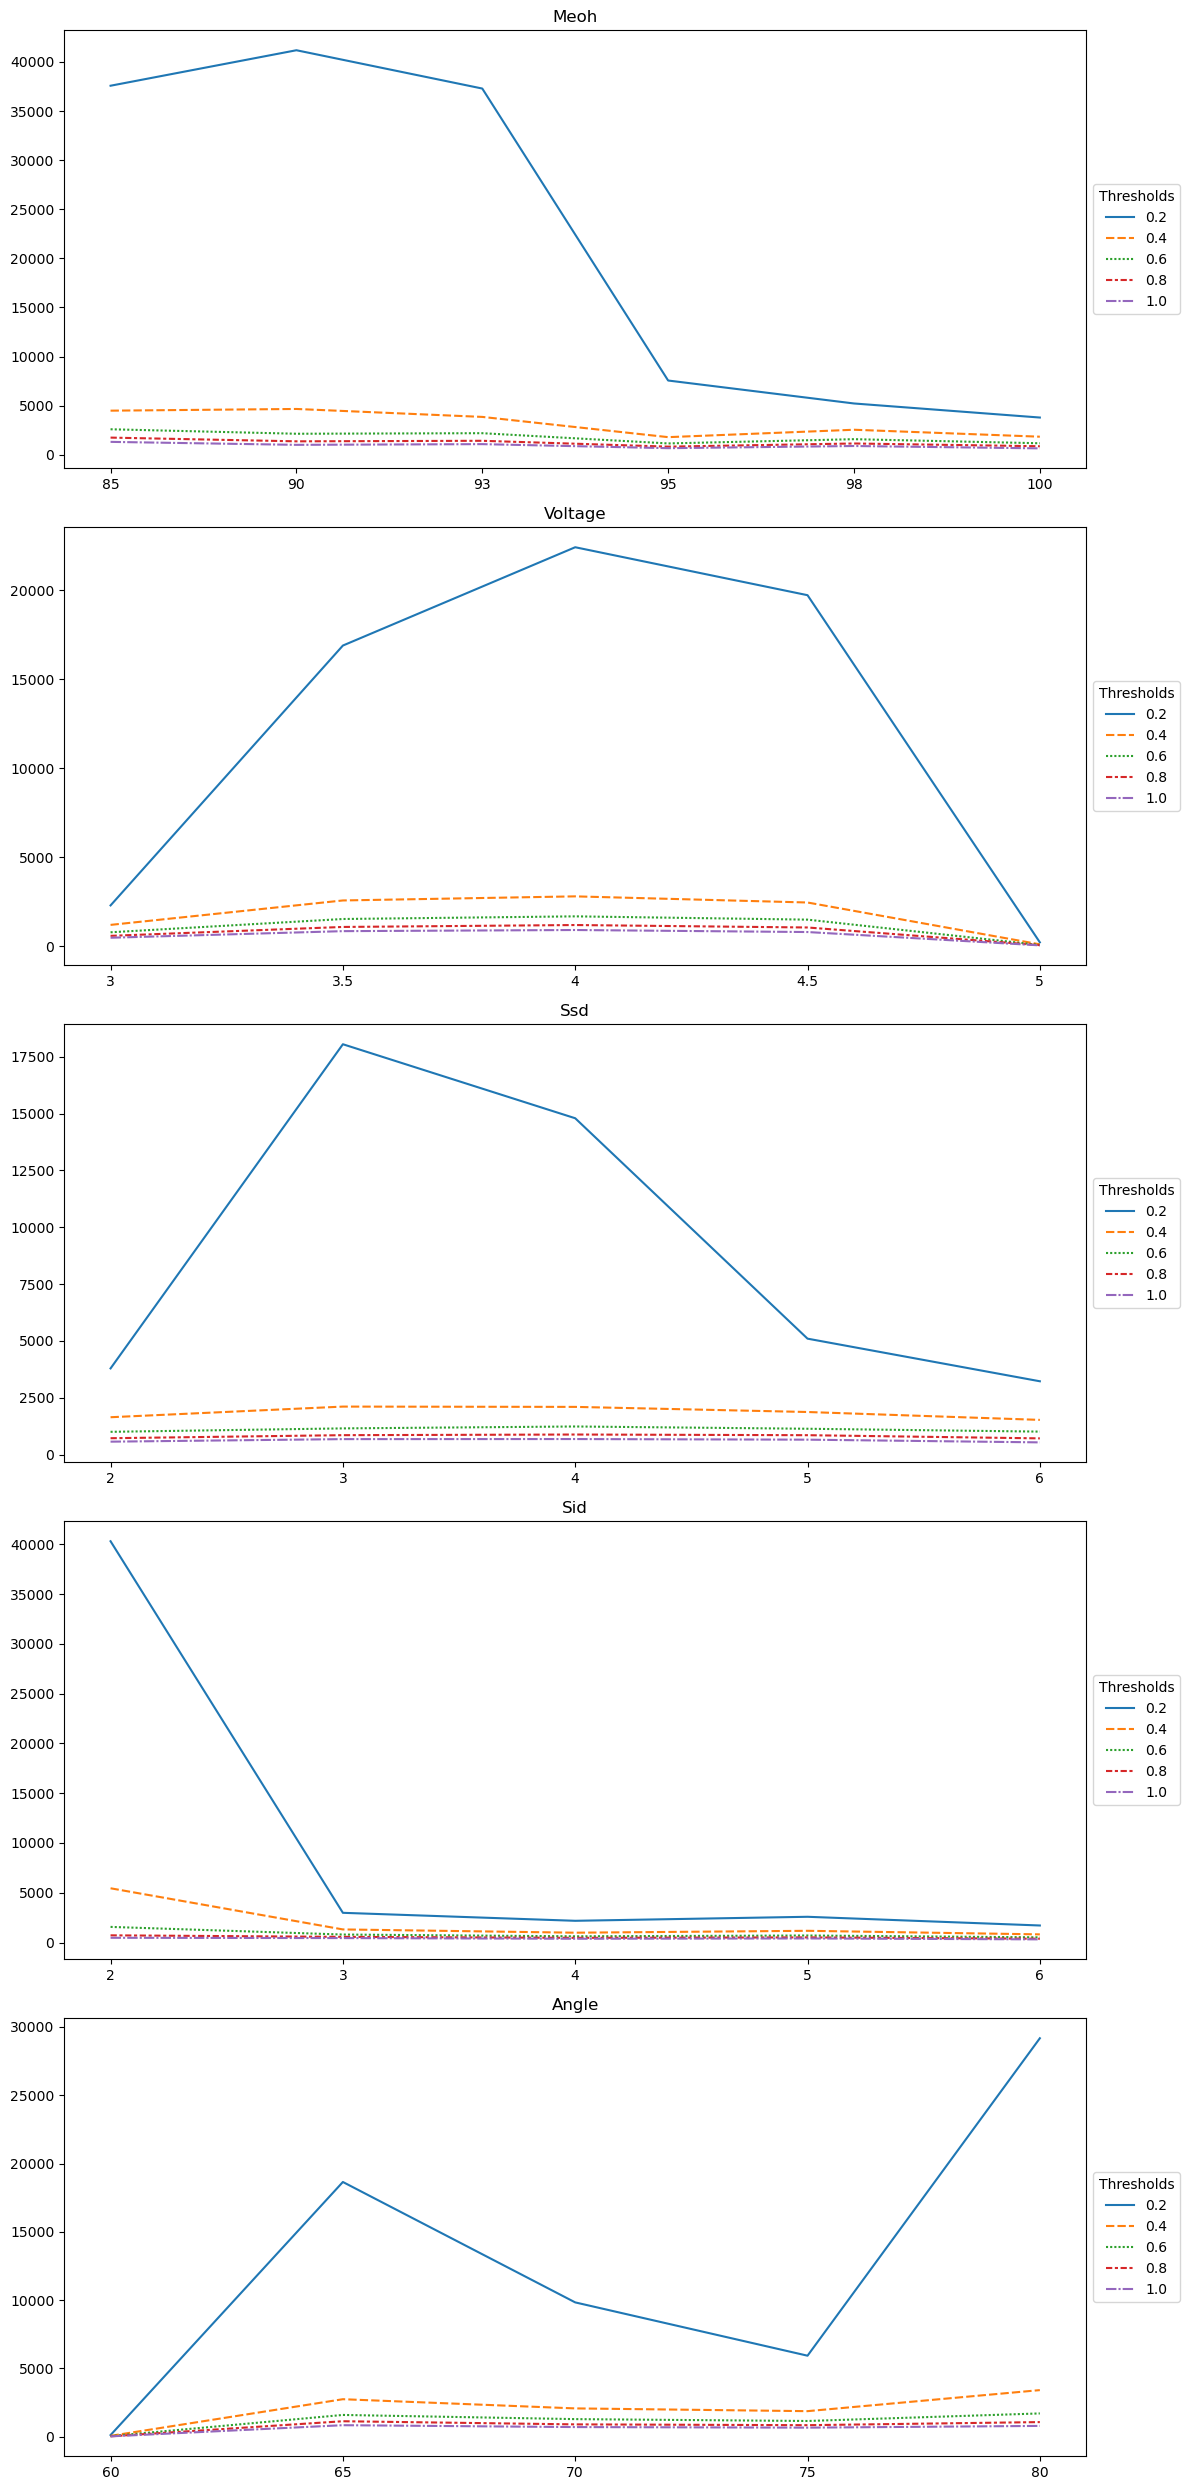

In [41]:
# Get mean number of features and save it
number_of_features_df = pd.DataFrame(
  number_of_features
)
number_of_features_df.columns = number_of_features_df.columns.map(
    file_to_sample_file_map.get
)

plot_optimization_parameters(number_of_features_df, "")

In [ ]:
def mean_number_of_features(metadata_df):
  number_of_features = {}

  for _, roi in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
    common_representation_path = os.path.join(
        PROCESSED_DATA, f"{roi.sample_file_name}", "common_representation.imzML"
    )
    with ImzMLParser(common_representation_path) as p:
      # Read MSI data and get the intensity matrix
      _, msi = read_msi(p)
      #
      mean_spectra = np.mean(msi, axis=(0, 1))
      #
      number_of_features[roi.file_name] = {}
      for threshold in THRESHOLDS:
        number_of_features[roi.file_name][threshold] = (
            spectra_significant_features_threshold(mean_spectra, threshold)
        )
  return number_of_features


def spectra_wise_number_of_features(metadata_df):
  number_of_features = {}

  for _, roi in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
    common_representation_path = os.path.join(
        PROCESSED_DATA, f"{roi.sample_file_name}", "common_representation.imzML"
    )
    with ImzMLParser(common_representation_path) as p:
      _, msi = read_msi(p)
      #
      number_of_features[roi.file_name] = {}
      for threshold in THRESHOLDS:
        msi_num_features = []
        for i, j in np.ndindex(msi.shape[:2]):
          spectra = msi[i, j, :]
          msi_num_features.append(
              spectra_significant_features_threshold(spectra, threshold)
          )
        number_of_features[roi.file_name][threshold] = np.mean(
            msi_num_features
        ), np.std(msi_num_features)
  return number_of_features


def plot_optimization_parameters(
    df, save_path, std_df=None,
    parameters=["MeOH", "voltage", "ssd", "sid", "angle"]
):
  fig, axes = plt.subplots(
      nrows=len(parameters), ncols=1, figsize=(12, len(parameters) * 5),
      sharex=False
  )
  fig.subplots_adjust(hspace=0.5)

  for ax, optimization_parameter in zip(axes, parameters):
    cols = df.columns.map(lambda col: optimization_parameter in col)
    cols_names = [col.split("_")[-1] for col in df.columns[cols]]

    mean_values = df.loc[:, cols].T
    sns.lineplot(mean_values, ax=ax)

    if std_df is not None:
      std_values = std_df.loc[:, cols].T
      for i, col in enumerate(mean_values.columns):
        ax.fill_between(
            range(mean_values.shape[0]), mean_values[col] - std_values[col],
            mean_values[col] + std_values[col], alpha=0.2
        )

    ax.set_xticks(range(len(cols_names)))
    ax.set_xticklabels(cols_names)
    ax.set_title(optimization_parameter.capitalize())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(title="Thresholds", loc='center left', bbox_to_anchor=(1, 0.5))

  plt.tight_layout()
  plt.savefig(save_path, bbox_inches='tight', dpi=1200, transparent=True)
  plt.show()


def plot_number_of_features_heatmap(df, threshold, save_path):
  cols = df.columns.map(lambda col: "pressure_flow_rate" in col)
  series = df.loc[threshold, cols]

  # Extracting the unique pressures and flow rates
  pressures = sorted(
      set(int(key.split('_')[-1].split('-')[0]) for key in series.index)
  )
  flow_rates = sorted(set(float(key.split('-')[1]) for key in series.index))

  # Creating a DataFrame for the heatmap
  heatmap_data = pd.DataFrame(index=pressures, columns=flow_rates)

  # Populating the DataFrame with the data
  for key, value in series.items():
    pressure, flow_rate = key.split('_')[-1].split('-')
    heatmap_data.at[int(pressure), float(flow_rate)] = value

  # Converting the DataFrame to numpy array for plotting
  heatmap_data = heatmap_data.astype(float).to_numpy()

  # Plotting the heatmap
  plt.figure(figsize=(8, 6))
  plt.imshow(heatmap_data, aspect='auto', cmap='magma', origin='lower')
  plt.colorbar(label='Number of features')
  plt.xticks(ticks=np.arange(len(flow_rates)), labels=flow_rates)
  plt.yticks(ticks=np.arange(len(pressures)), labels=pressures)
  plt.xlabel('Flow Rate [μL/min]')
  plt.ylabel('Pressure [bar]')
  plt.title('Heatmap of Number of Features')
  plt.tight_layout()
  plt.savefig(save_path, bbox_inches='tight', dpi=1200, transparent=True)
  plt.show()


def mean_tic(metadata_df):
  sample_tics = {}
  for _, roi in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
    #
    raw_path = os.path.join(ALIGNED_DATA, f"{roi.file_name}.imzML")
    #
    with ImzMLParser(raw_path) as reader:
      intensities = {}
      # Loop over each spectra in MSI
      for idx, _ in enumerate(reader.coordinates):
        raw_mzs, raw_intensities = reader.getspectrum(idx)
        for mz, intensity in zip(raw_mzs, raw_intensities):
          temp_intensities = intensities.get(mz, [])
          temp_intensities.append(intensity)
          intensities[mz] = temp_intensities
      sample_tics[roi.file_name] = np.array(
          [np.mean(intensities[mz]) for mz in intensities.keys()]
      ).sum()
  return sample_tics


def spectra_wise_tic(metadata_df):
  sample_tics = {}
  for _, roi in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
    #
    raw_path = os.path.join(ALIGNED_DATA, f"{roi.file_name}.imzML")
    #
    with ImzMLParser(raw_path) as reader:
      tics = []
      # Loop over each spectra in MSI
      for idx, _ in enumerate(reader.coordinates):
        _, raw_intensities = reader.getspectrum(idx)
        tics.append(raw_intensities.sum())

      sample_tics[roi.file_name] = {'mean': np.mean(tics), 'std': np.std(tics)}
  return sample_tics


def plot_optimization_parameters_tic(
    spectra_mean_df, save_path, spectra_std_df=None,
    optimization_parameters=["MeOH", "voltage", "ssd", "sid", "angle"]
):

  fig, axes = plt.subplots(len(optimization_parameters), 1, figsize=(10, 20))

  for optimization_parameter, ax in zip(
      optimization_parameters, axes.flatten()
  ):
    cols = spectra_mean_df.columns.map(
        lambda col: optimization_parameter in col
    )
    cols_names = [col.split("_")[-1] for col in spectra_mean_df.columns[cols]]

    means = spectra_mean_df.loc[:, cols].values.flatten()

    sns.lineplot(x=range(len(cols_names)), y=means, ax=ax, color="tab:red")

    if spectra_std_df is not None:
      stds = spectra_std_df.loc[:, cols].values.flatten()
      ax.errorbar(
          x=range(len(cols_names)), y=means, yerr=stds, fmt='o', capsize=5,
          color="tab:red"
      )

    ax.set_xticks(range(len(cols_names)))
    ax.set_xticklabels(cols_names)
    ax.set_title(optimization_parameter.capitalize())

    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y')

  plt.tight_layout()
  plt.savefig(save_path, bbox_inches='tight', dpi=1200, transparent=True)
  plt.show()


def plot_tic_heatmap(df, save_path):
  cols = df.columns.map(lambda col: "pressure_flow_rate" in col)
  series = df.loc[0, cols]

  # Extracting the unique pressures and flow rates
  pressures = sorted(
      set(int(key.split('_')[-1].split('-')[0]) for key in series.index)
  )
  flow_rates = sorted(set(float(key.split('-')[1]) for key in series.index))

  # Creating a DataFrame for the heatmap
  heatmap_data = pd.DataFrame(index=pressures, columns=flow_rates)

  # Populating the DataFrame with the data
  for key, value in series.items():
    pressure, flow_rate = key.split('_')[-1].split('-')
    heatmap_data.at[int(pressure), float(flow_rate)] = value

  # Converting the DataFrame to numpy array for plotting
  heatmap_data = heatmap_data.astype(float).to_numpy()

  # Plotting the heatmap
  plt.figure(figsize=(8, 6))
  im = plt.imshow(heatmap_data, aspect='auto', cmap='magma', origin='lower')
  cbar = plt.colorbar(im, format=FuncFormatter(lambda x, _: f'{x:.0f}'))
  cbar.set_label('TIC')
  plt.xticks(ticks=np.arange(len(flow_rates)), labels=flow_rates)
  plt.yticks(ticks=np.arange(len(pressures)), labels=pressures)
  plt.xlabel('Flow Rate [μL/min]')
  plt.ylabel('Pressure [bar]')
  plt.title('Heatmap of TIC')
  plt.tight_layout()
  #plt.savefig(save_path, bbox_inches='tight', dpi=1200, transparent=True)
  plt.show()


if __name__ == '__main__':
  # Read metadata
  metadata_df = pd.read_csv(METADATA_PATH)
  # Define map from file to sample_file
  file_to_sample_file_map = pd.Series(
      metadata_df.sample_file_name.values, index=metadata_df.file_name
  ).to_dict()

  # Get mean number of features and save it
  mean_number_of_features_df = pd.DataFrame(
      mean_number_of_features(metadata_df)
  )
  mean_number_of_features_df.to_csv(
      PLOT_PATH / "mean_spectra_number_of_features.csv"
  )
  mean_number_of_features_df.columns = mean_number_of_features_df.columns.map(
      file_to_sample_file_map.get
  )

  # Get spectra wise number of features and save it
  spectra_wise_number_of_features_numpy = spectra_wise_number_of_features(
      metadata_df
  )
  spectra_wise_number_of_features_mean_df = pd.DataFrame(
      {
          key: {sub_key: sub_value[0]
                for sub_key, sub_value in value.items()}
          for key, value in spectra_wise_number_of_features_numpy.items()
      }
  )
  spectra_wise_number_of_features_std_df = pd.DataFrame(
      {
          key: {sub_key: sub_value[1]
                for sub_key, sub_value in value.items()}
          for key, value in spectra_wise_number_of_features_numpy.items()
      }
  )
  spectra_wise_number_of_features_mean_df.to_csv(
      PLOT_PATH / "spectra_wise_number_of_features_mean.csv"
  )
  spectra_wise_number_of_features_std_df.to_csv(
      PLOT_PATH / "spectra_wise_number_of_features_std.csv"
  )
  spectra_wise_number_of_features_mean_df.columns = (
      spectra_wise_number_of_features_mean_df.columns.map(
          file_to_sample_file_map.get
      )
  )
  spectra_wise_number_of_features_std_df.columns = (
      spectra_wise_number_of_features_std_df.columns.map(
          file_to_sample_file_map.get
      )
  )

  # Plot optimization parameters number of features
  plot_optimization_parameters(
      mean_number_of_features_df, PLOT_PATH / "mean_number_of_features.png"
  )
  plot_optimization_parameters(
      spectra_wise_number_of_features_mean_df,
      PLOT_PATH / "pixel_wise_number_of_features.png"
  )
  plot_optimization_parameters(
      spectra_wise_number_of_features_mean_df,
      PLOT_PATH / "pixel_wise_number_of_features_with_std.png",
      std_df=spectra_wise_number_of_features_std_df
  )
  #
  plot_number_of_features_heatmap(
      mean_number_of_features_df, 0.01,
      PLOT_PATH / "mean_number_of_features_heatmap.png"
  )

  # Get mean TIC and save it
  mean_tic_numpy = mean_tic(metadata_df)
  mean_tic_df = pd.DataFrame(mean_tic_numpy, index=[0])
  mean_tic_df.to_csv(PLOT_PATH / "mean_tic.csv")
  mean_tic_df.columns = mean_tic_df.columns.map(file_to_sample_file_map.get)

  # Get spectra wise TIC and save it
  spectra_wise_tic_dict = spectra_wise_tic(metadata_df)
  spectra_wise_tic_mean_df = pd.DataFrame(
      {key: value['mean'] for key, value in spectra_wise_tic_dict.items()},
      index=[0]
  )

  spectra_wise_tic_std_df = pd.DataFrame(
      {key: value['std'] for key, value in spectra_wise_tic_dict.items()},
      index=[0]
  )
  spectra_wise_tic_mean_df.to_csv(PLOT_PATH / "spectra_wise_tic_mean.csv")
  spectra_wise_tic_mean_df.columns = spectra_wise_tic_mean_df.columns.map(
      file_to_sample_file_map.get
  )
  spectra_wise_tic_std_df.to_csv(PLOT_PATH / "spectra_wise_tic_std.csv")
  spectra_wise_tic_std_df.columns = spectra_wise_tic_std_df.columns.map(
      file_to_sample_file_map.get
  )

  #
  plot_optimization_parameters_tic(mean_tic_df, PLOT_PATH / "mean_tic.png")
  plot_optimization_parameters_tic(
      spectra_wise_tic_mean_df, PLOT_PATH / "pixel_wise_tic.png",
      spectra_wise_tic_std_df
  )

  #
  plot_tic_heatmap(mean_tic_df, PLOT_PATH / "mean_tic_heatmap.png")
